In [1]:
import matplotlib.pyplot as plt 
import numpy as np

from time import time
from PIL import Image

import torch
import torchvision.transforms as transforms

from hemul.cipher import *
from hemul.scheme import *

device = "cpu"

In [2]:
from load_test_model import get_test_model

org_model = get_test_model()
# specify the image classes
org_model

ConvNeuralNet(
  (conv_layer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_layer4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [3]:
fn_param = "SimpleCNN_ReLU_minimax_v2.pt"

trained_param = torch.load(fn_param, map_location=torch.device(device))
trained_param = {k: v.cpu() for k, v in trained_param.items()} # to cpu()
org_model.load_state_dict(trained_param)
org_model.eval() ## If not eval(), running_mean and running_var of batch_norm changes

# To numpy
params_np = {k: v.numpy() for k, v in trained_param.items()}

torch.Size([1, 3, 32, 32])


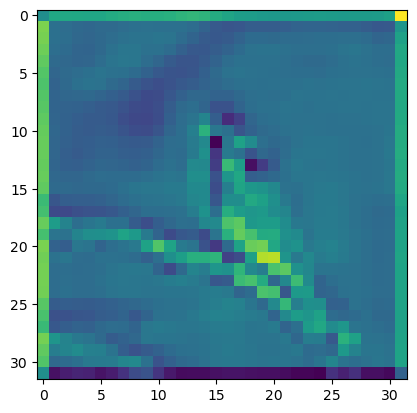

In [4]:
img = np.array(Image.open("./bird6.png"))
to_tensor = transforms.ToTensor() # [n_channel, nh, nw]
img_tensor = to_tensor(img).unsqueeze(0) # [n_batch, n_channel, nh, nw]
n_batch, n_channel, nh, nw = img_tensor.shape

print(img_tensor.shape)

org_tt0 = org_model.conv_layer1(img_tensor)

x2 = org_tt0[0,0,...].detach().numpy()

plt.imshow(x2)

## GAZELLE

In [5]:
from math import floor, ceil, sqrt

In [6]:
img_tensor.shape

torch.Size([1, 3, 32, 32])

In [7]:
img2d = np.array(img_tensor[0,0,:,:])

wi, hi = img2d.shape

In [8]:
# kernel
kernel = org_model.conv_layer1.weight.detach().numpy()

k2d = kernel[0,0,:,:]
fw, fh = k2d.shape

print(k2d)

[[-0.03024577  0.07654995  0.05950021]
 [ 0.00516844 -0.03511824 -0.11581486]
 [-0.06510032 -0.08480114 -0.10425694]]


### 1. padded SISO 스킵

In [9]:
if False:
    nslots = 2**14

    pad = int((fw -1) / 2)
    padded = np.zeros((wi+fw-1, hi+fh-1))

    padded[pad:-pad, pad:-pad] = ch1_2d

    raster_scan = padded.ravel()

    ctxt = np.zeros(nslots)
    ctxt[:len(raster_scan)] = raster_scan

### 2. Packed SISO
- nslots = wi * hi

In [10]:
nslots = wi*hi

raster_scan = img2d.ravel()

In [11]:
# convolve

## rotate input
# fw * fh -1 rotations
rotated = []
ctd = np.zeros(nslots)

for i1 in range(fh):
    cti1=[]
    for i2 in range(fw):
        roll = -wi*int(i1-(fh-1)/2) + int(i2-(fw-1)/2)
        if roll != 0:
            cti1.append(np.roll(raster_scan, roll)) 
        else:
            cti1.append(raster_scan)
    rotated.append(cti1)

In [12]:
def MultWgt_bck(hi,wi, ifh, ifw, kernel):
    Uout = np.ones((hi, wi))
    range_h = np.arange(hi)
    range_w = np.arange(wi)
    fh, fw = kernel.shape
    pad_h = int((fh-1)/2) # height 방향 padding
    pad_w = int((fw-1)/2) # width 방향 padding
    for ihi in range(hi): # hi
        for iwi in range(wi): # wi
            #for i5 in range(n5): # ti
            if  not ((ihi - pad_h + ifh) in range_h) or \
                not ((iwi - pad_w + ifw) in range_w):
                Uout[ihi,iwi] = 0
            else:
                pass
                #Uout[ihi,iwi] = 1
    return Uout


def weight_mask(hi,wi, ifh, ifw, fh, fw):
    Uout = np.ones((hi, wi))
    pad_h = int((fh-1)/2) # height 방향 padding
    pad_w = int((fw-1)/2) # width 방향 padding

    if ifh < pad_h:
        Uout[:pad_h,:] = 0 # 위로 넘음
    elif ifh >= (fh - pad_h): # 2 >= 3 - 1
        Uout[-(pad_h):,:] = 0 # 아래로 넘음
    
    if ifw < pad_w:
        Uout[:,:pad_w] = 0 # 좌로 넘음
    elif ifw >= (fw - pad_w): # 
        Uout[:,-(pad_w):] = 0 # 우로 넘음
    
    return Uout

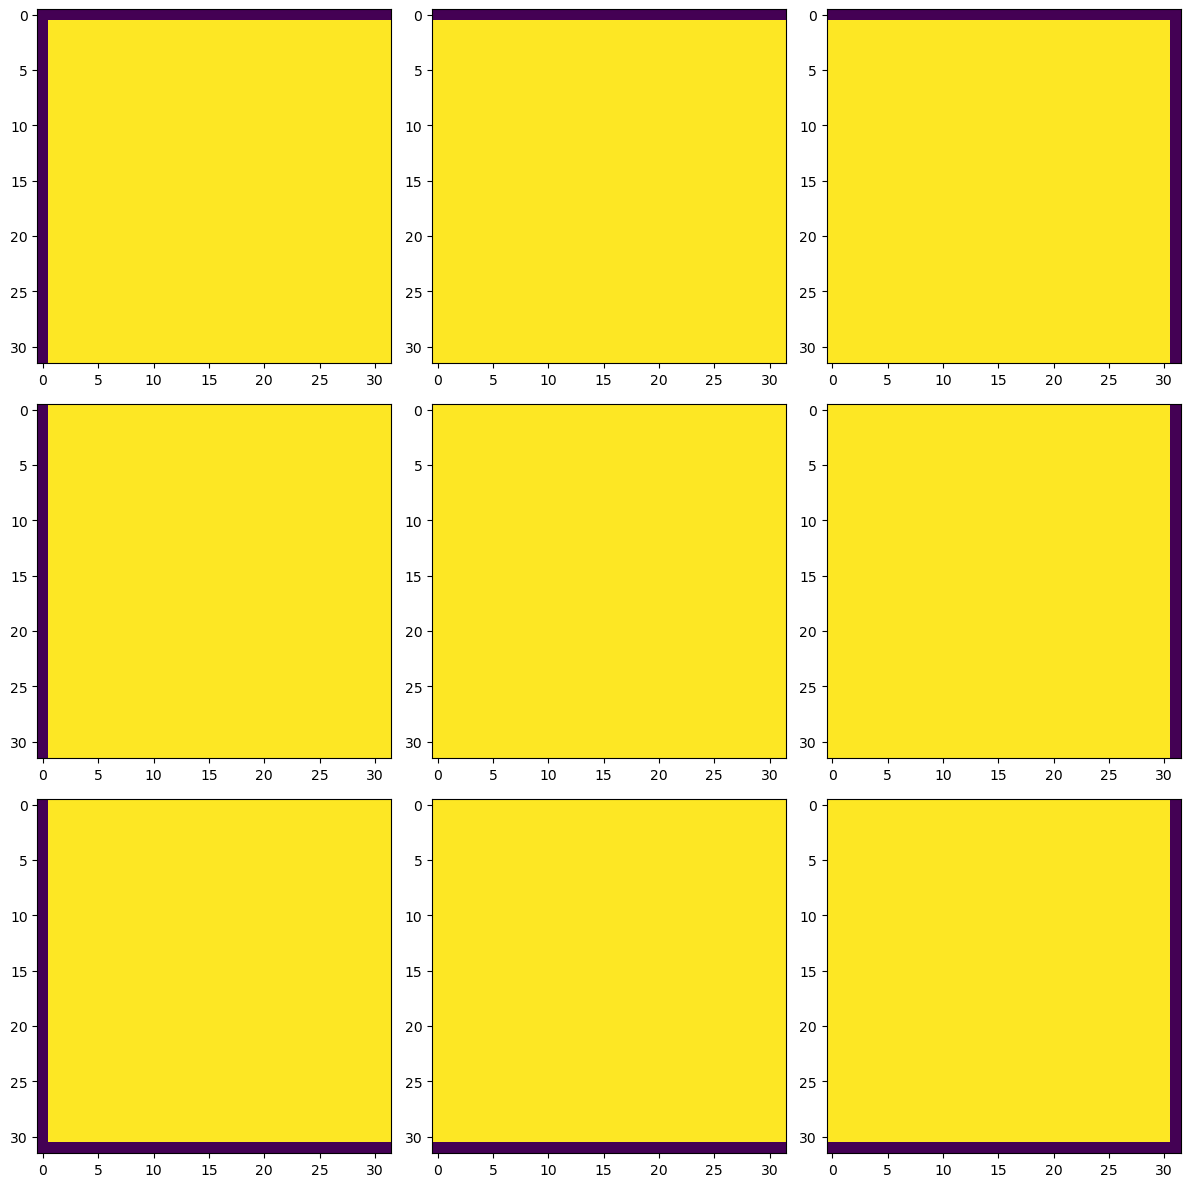

In [14]:
fig, axs = plt.subplots(3,3, figsize=(12,12))

ctb = np.zeros(nslots)
pad_h = int((fh-1)/2) # height 방향 padding
pad_w = int((fw-1)/2) # width 방향 padding
for i1 in range(fh):
    for i2 in range(fw):
        Uout = weight_mask(hi, wi, i1, i2, fh, fw)
        axs[i1,i2].imshow(Uout, vmax=1, vmin=0)
        
        multwgt = np.zeros(nslots)
        multwgt[:hi*wi] = Uout.ravel() * k2d[i1,i2]
        
        #get_Up(Uout, Uin, i1, i2, i, ki, fh, fw, hi, wi, ci)
        #multwgt = VEC(Uout, nslots)
        #len_multwgt = len(multwgt)
        ctb += rotated[i1][i2] * multwgt # multc

plt.tight_layout()

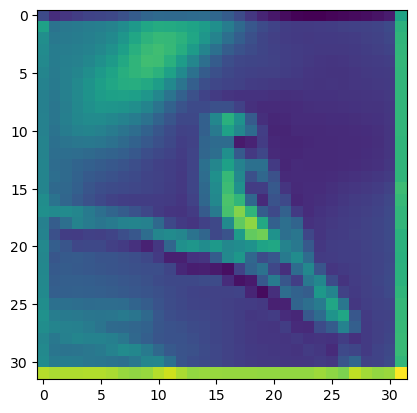

In [126]:
plt.imshow(ctb[:hi*wi].reshape(hi,wi))
plt.show()

rot: 9 - 1; 
multc: 9

## Channel packing

In [15]:
def weight_mask(Uout, hi,wi, ifh, ifw, fh, fw):
    pad_h = int((fh-1)/2) # height 방향 padding
    pad_w = int((fw-1)/2) # width 방향 padding

    if ifh < pad_h:
        Uout[:pad_h,:] = 0 # 위로 넘음
    elif ifh >= (fh - pad_h): # 2 >= 3 - 1
        Uout[-(pad_h):,:] = 0 # 아래로 넘음
    
    if ifw < pad_w:
        Uout[:,:pad_w] = 0 # 좌로 넘음
    elif ifw >= (fw - pad_w): # 
        Uout[:,-(pad_w):] = 0 # 우로 넘음
    
    #return Uout

In [16]:
img3d = np.array(img_tensor[0,:,:,:])

nc, wi, hi = img3d.shape

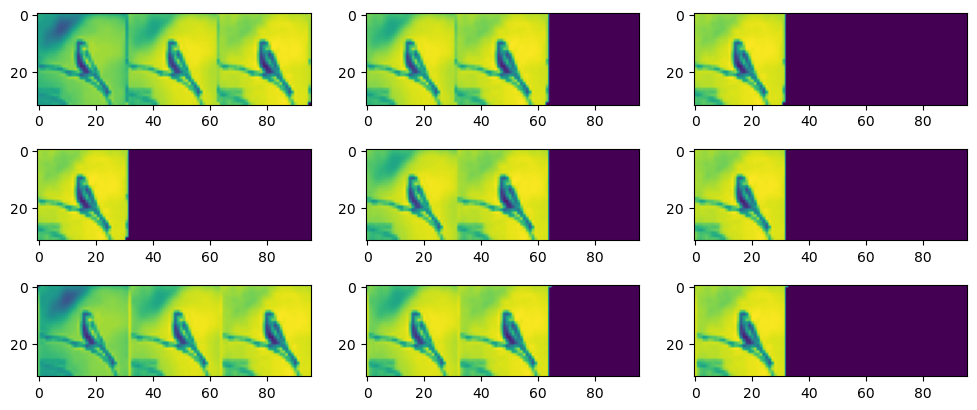

In [39]:
nc = 3
nslots = 2**14

# convolve

## rotate input
#ctd = np.zeros(nslots)

fig, axs = plt.subplots(3,3, figsize=(12,5))

raster_scan = img3d.ravel()

diag_rotated = []
for i1 in range(fh):
    cti1=[]
    for i2 in range(fw):
        mc_img = np.zeros(nslots)
        mc_img[:len(raster_scan)] = raster_scan
        mc_rotated = []
        for i3 in range(nc):
            roll = -wi*int(i1-(fh-1)/2) + int(i2-(fw-1)/2) - i3*wi*hi
            # ctxt가 꽉 차지 않을 경우 빈칸이 돌아들어옴.
            # 그렇다고 이미지 모양을 바꾸면 안 되고 여기에 kernel 위치도 맞춰야함. 
            # 왜냐면 encrypt된 이후로는 이미지 낱장으로 shuffle을 할 수 없기 때문.
            if roll != 0:
                rotated = np.roll(mc_img, roll)
            mc_rotated.append(rotated)
            if i1==1:
                axs[i2,i3].imshow(np.hstack([rotated[:1024].reshape(32,32), 
                               rotated[1024:2048].reshape(32,32),
                               rotated[2048:3072].reshape(32,32)]))
        cti1.append(mc_rotated)
    diag_rotated.append(cti1)

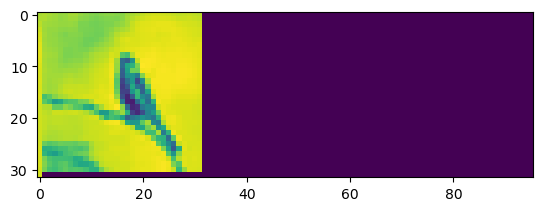

In [34]:
plt.imshow(

In [19]:
print(len(diag_rotated)) # fh
print(len(diag_rotated[0])) # fw
print(len(diag_rotated[0][0])) # nc
print(len(diag_rotated[0][0][0]))

3
3
3
16384


[[[-0.03024577  0.07654995  0.05950021]
  [ 0.00516844 -0.03511824 -0.11581486]
  [-0.06510032 -0.08480114 -0.10425694]]

 [[ 0.02362125  0.10353491  0.11222558]
  [ 0.08154692  0.16033892  0.01494425]
  [ 0.02821626  0.11298375  0.07297881]]

 [[-0.14998762 -0.13937311 -0.06930704]
  [-0.07343121 -0.04457783 -0.09344603]
  [ 0.04625637  0.01283144  0.03862176]]]
__________________________
0 0 0
675.8274658843875
[-0.         -0.03024577 -0.03024577 -0.03024577]
__________________________
0 0 1
830.9058926254511
[0.         0.02362125 0.02362125 0.02362125]
__________________________
0 0 2
874.8431444391608
[-0.         -0.14998762 -0.14998762 -0.14998762]
__________________________
0 1 0
675.2588384076953
[0.         0.07654995 0.07654995 0.07654995]
__________________________
0 1 1
830.7568730264902
[0.         0.10353491 0.10353491 0.10353491]
__________________________
0 1 2
874.7647130712867
[-0.         -0.13937311 -0.13937311 -0.13937311]
__________________________
0 2 0
674.521

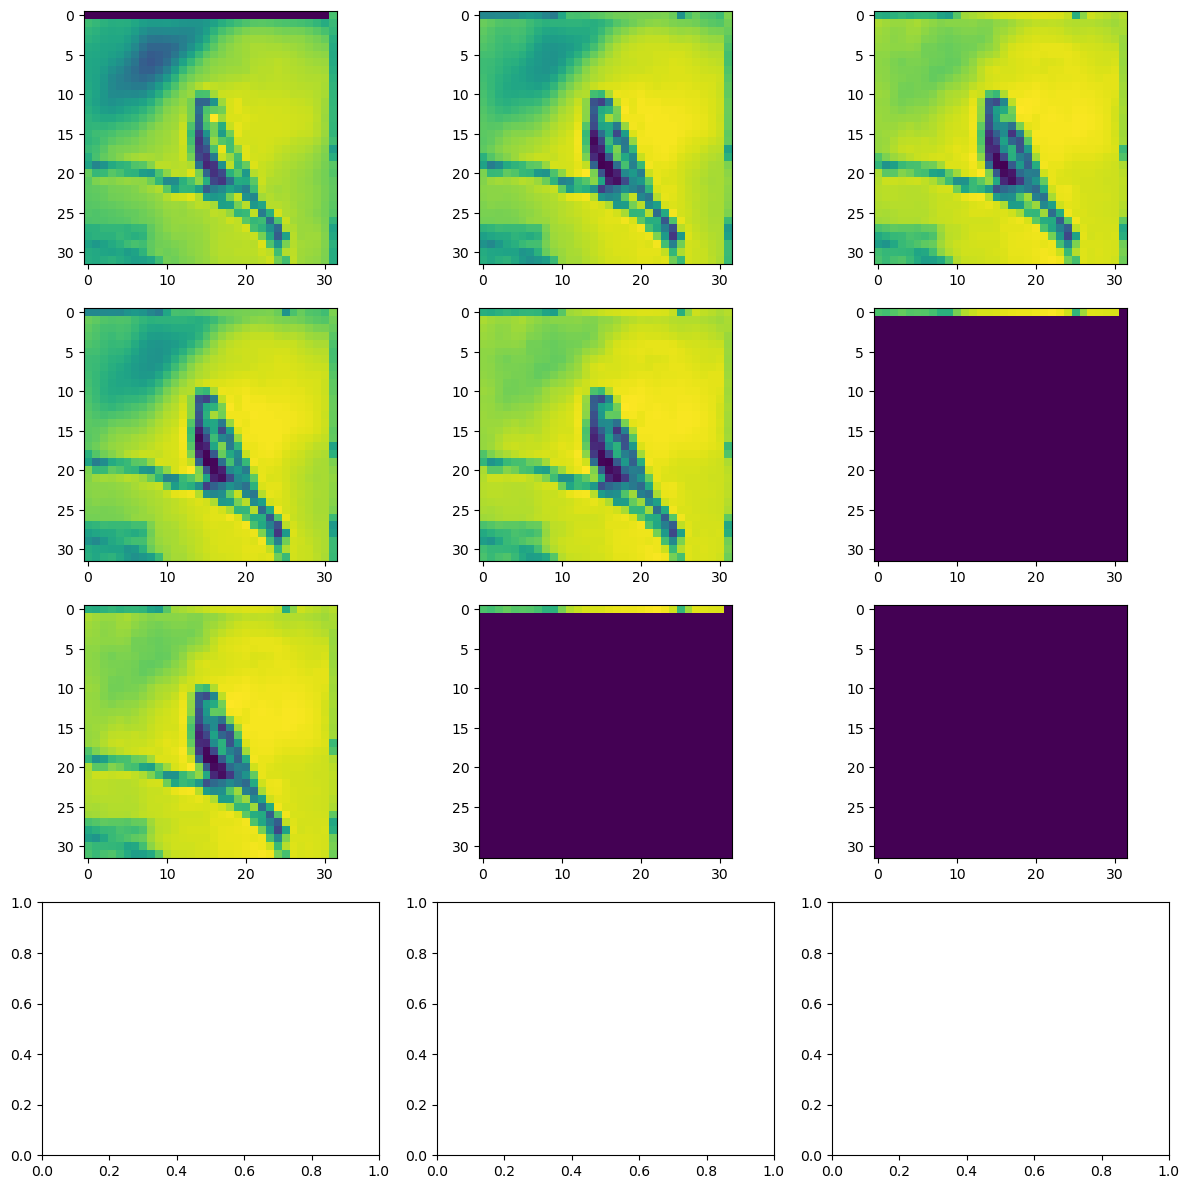

In [20]:
fig, axs = plt.subplots(4,3, figsize=(12,12))
k3d = kernel[0,:,:,:]
nc_ch, fw, fh = k3d.shape

print(k3d)

ctb = np.zeros(nslots)
pad_h = int((fh-1)/2) # height 방향 padding
pad_w = int((fw-1)/2) # width 방향 padding

npix = hi*wi
for i1 in range(fh):
    for i2 in range(fw):
        multwgt = np.zeros(nslots)
        for i3 in range(nc): # channel
            Uout = np.ones((hi, wi))
            weight_mask(Uout, hi, wi, i1, i2, fh, fw)
            
            #axs[i1,i2].imshow(Uout, vmax=1, vmin=0)
            multwgt[i3*npix:(i3+1)*npix] = Uout.ravel() * k3d[i3,i1,i2]
        
        for i3 in range(nc): # channel            
            diag_multwgt = np.roll(multwgt, -i3*npix)

            #get_Up(Uout, Uin, i1, i2, i, ki, fh, fw, hi, wi, ci)
            #multwgt = VEC(Uout, nslots)
            #len_multwgt = len(multwgt)
            diag_img = diag_rotated[i1][i2][i3]
            if i1 == i2 == 0:
                axs[i3,0].imshow(diag_img[:1024].reshape(32,32))
                axs[i3,1].imshow(diag_img[1024:2048].reshape(32,32))
                axs[i3,2].imshow(diag_img[2048:3072].reshape(32,32))
            
            print("__________________________")
            print(i1,i2,i3)
            print(np.sum(diag_img[:1024]))#, np.sum(diag_img[1024:2048]), np.sum(diag_img[2048:3072]))
            print(diag_multwgt[:1024:260])#, np.sum(diag_multwgt[1024:2048]), np.sum(diag_multwgt[2048:3072]))
            
            ctb += diag_img * diag_multwgt # multc

plt.tight_layout()

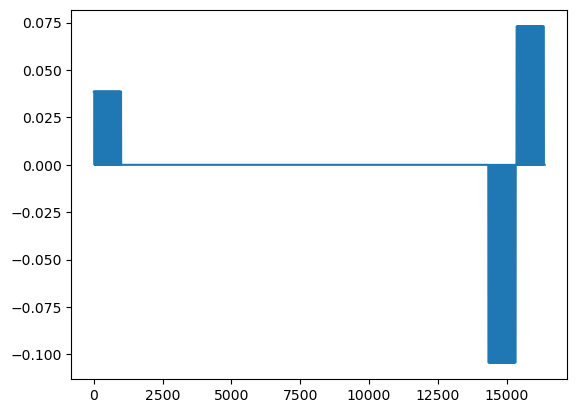

In [21]:
plt.plot(diag_multwgt)

In [22]:
k3d

array([[[-0.03024577,  0.07654995,  0.05950021],
        [ 0.00516844, -0.03511824, -0.11581486],
        [-0.06510032, -0.08480114, -0.10425694]],

       [[ 0.02362125,  0.10353491,  0.11222558],
        [ 0.08154692,  0.16033892,  0.01494425],
        [ 0.02821626,  0.11298375,  0.07297881]],

       [[-0.14998762, -0.13937311, -0.06930704],
        [-0.07343121, -0.04457783, -0.09344603],
        [ 0.04625637,  0.01283144,  0.03862176]]], dtype=float32)

In [23]:
def plot_3ch(img, npix=1024):
    img1, img2, img3 = img[:npix], img[npix:2*npix], img[2*npix:3*npix]    
    fig, axs = plt.subplots(2,2)
    axs = axs.ravel()
    axs[0].imshow(img1.reshape(32,32))
    axs[1].imshow(img2.reshape(32,32))
    axs[2].imshow(img3.reshape(32,32))
    plt.show()

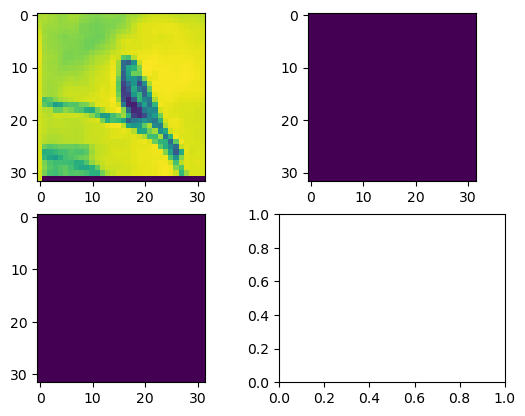

In [87]:
plot_3ch(diag_img)

In [88]:
plt.close()

In [24]:
ans_ch00 = org_tt0[0,0,...].detach().numpy().reshape(32,32)

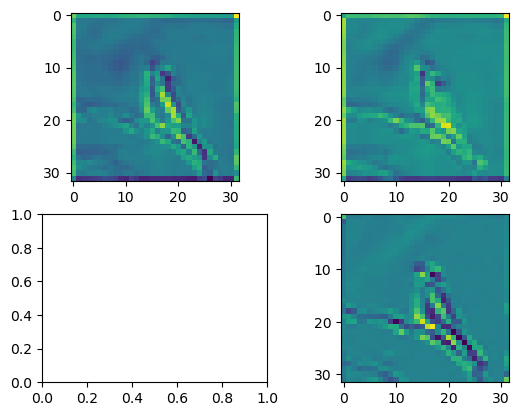

In [25]:
fig, axs = plt.subplots(2,2)
res = ctb[:1024].reshape(32,32)
vmin, vmax = res.min(), res.max()
axs[0,0].imshow(res, vmin=vmin, vmax=vmax)
axs[0,1].imshow(ans_ch00, vmin=vmin, vmax=vmax)
axs[1,1].imshow(res - ans_ch00, vmin=vmin, vmax=vmax)